In [106]:
import numpy as np
import copy

path = 'dataset/dataset07.2.18.csv'
dataset = np.genfromtxt(path, delimiter=';')

X = copy.deepcopy(dataset[:,1:7])
y = dataset[:,9]

In [107]:
# data transform
v1=X[:,1]
h=X[:,0]
X2 = copy.deepcopy(X)
X2[:,2:] =X[:,2:]/v1[:,None]
X2[:,5:7] =X[:,5:7]

# explain the features

In [109]:
import torch
import torch.nn as nn                     
import torch.nn.functional as F           
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim               

In [112]:
batch_size = 64

nData = X2.shape[0]

X_tensor = torch.tensor(X2,dtype=torch.float)
y_tensor = torch.tensor(y,dtype=torch.float)

dataset = torch.utils.data.TensorDataset( X_tensor, y_tensor)

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset,[int(0.8*nData),int(0.1*nData)\
                                                                     ,nData-int(0.8*nData)-int(0.1*nData)])

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True, num_workers=2)

In [113]:
class FullNet(nn.Module):
    def __init__(self,ninputs=6):
            super(FullNet, self).__init__()
            
            self.linear_relu_stack = nn.Sequential(
                nn.Linear(in_features=ninputs, out_features=100),
                nn.ReLU(),
                nn.Linear(in_features=100, out_features=64),
                nn.ReLU(),
                nn.Linear(in_features=64, out_features=32),
                nn.ReLU(),
                nn.Linear(in_features=32, out_features=1),  
                nn.Sigmoid()
            )
            
    def forward(self, x):
            logits = self.linear_relu_stack(x)
            return logits

In [114]:
model = FullNet()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
scheduler = StepLR(optimizer, step_size=1, gamma=0.99)

epochs = 50

In [115]:
train_loss=[]
validation_loss=[]
loss_fn = torch.nn.BCELoss(reduction='sum')

for epoch in range(epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    
    model.train()
    for i, data in enumerate(trainloader, 0):
        inputs, ytrue = data     
        outputs = model(inputs)
        loss = loss_fn(outputs.squeeze(),ytrue)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
      
    running_loss = running_loss/(i+1)
    scheduler.step()
    train_loss.append(running_loss)
    
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for i, data in enumerate(valloader, 0):
            inputs, ytrue = data     
            outputs = model(inputs)
            loss = loss_fn(outputs.squeeze(),ytrue)
            val_loss += loss.item()
        
    val_loss = val_loss/(i+1)
    print('Epoch {} LOSS train {} LOSS val {}'.format(epoch,running_loss, val_loss))
    
print('Finished Training')

# early stopping

Epoch 0 LOSS train 38.18077027170282 LOSS val 27.484146118164062
Epoch 1 LOSS train 32.6643022738005 LOSS val 22.43608808517456
Epoch 2 LOSS train 26.01924813421149 LOSS val 15.82208744684855
Epoch 3 LOSS train 18.395900701221667 LOSS val 9.879414081573486
Epoch 4 LOSS train 12.877263433054873 LOSS val 6.4691956837972
Epoch 5 LOSS train 10.359632542258815 LOSS val 5.28697927792867
Epoch 6 LOSS train 9.419137653551603 LOSS val 4.76013062397639
Epoch 7 LOSS train 9.06870875233098 LOSS val 4.601936042308807
Epoch 8 LOSS train 8.801480657175967 LOSS val 4.373789886633555
Epoch 9 LOSS train 8.618546981560556 LOSS val 4.311737775802612
Epoch 10 LOSS train 8.398360992732801 LOSS val 4.104975243409474
Epoch 11 LOSS train 8.239829157528124 LOSS val 4.000092347462972
Epoch 12 LOSS train 8.108753455312629 LOSS val 3.910353680451711
Epoch 13 LOSS train 7.917271614074707 LOSS val 3.757002909978231
Epoch 14 LOSS train 7.7593802935198735 LOSS val 3.7692333857218423
Epoch 15 LOSS train 7.6454468338113

# Evaluate in a function

In [116]:
x = np.linspace(0,1,100)
f_disc = lambda x,y : np.where((x < 0.25) | (x >0.5) , 0.1, 1.1) 
f_cont = lambda x,y : np.sin(2*np.pi*x)+1.01
f_cont_2 = lambda x,y : 2*(x-0.25)*(x-0.75)

f_disc_2 = lambda x,y : np.where((x < 0.25) | (x >0.5) , np.sin(2*np.pi*x)+1.1, 1.1) 

f_disc_3 = lambda x,y : np.where((x < 0.10) | (x >0.25) , 0.1, 1.1)+  np.where(x >0.25 , np.exp(-(x-0.5)**2/0.01), 0.0)

f_cont_3 = lambda x,y : np.sin(6*np.pi*x)+1.01


In [117]:
def generate_features(h,u_m,u_c,u_p):
    feature_vector = [h,u_c/u_c,u_m/u_c,u_p/u_c,(u_c-u_m)/h,(u_p-u_c)/h]
    feature_vector = np.array(feature_vector)
    return feature_vector

In [155]:
from matplotlib import pyplot as plt
    
def detect_disc(f,x,model):
    preds = []
    h = (x[-1]-x[0])/len(x)
    for i in range(len(x)):
        if i == 0:
            ic = 0
            ip = 1
            im = len(x)-2
        elif i == len(x)-1:
            ic = len(x)-1
            ip = 1
            im = len(x)-2
        else:
            ic = i
            ip = i+1
            im = i-1
        u_m = f[im]
        u_c = f[ic]
        u_p = f[ip]
        feature = generate_features(h,u_m,u_c,u_p)
        feature_t = torch.tensor(feature,dtype=torch.float)
        if i == 0 or i == len(x)-1:
            print(feature)
        pred = model(feature_t)
        preds.append(pred.detach().numpy())
    
    plt.plot(x,f)
    plt.plot(x,preds)

[0.01 1.   1.   1.   0.   0.  ]
[0.01 1.   1.   1.   0.   0.  ]


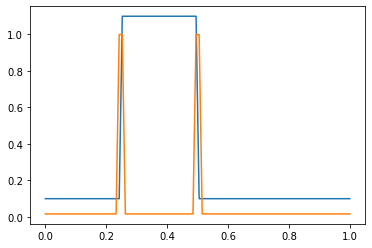

In [156]:
detect_disc(f_disc(x,None),x,model)

[0.01       1.         0.93720404 1.06279596 6.34239197 6.34239197]
[0.01       1.         0.93720404 1.06279596 6.34239197 6.34239197]


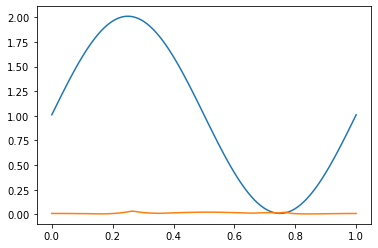

In [157]:
detect_disc(f_cont(x,None),x,model)

[ 0.01        1.          0.94667211  0.94667211  4.99948985 -4.99948985]
[ 0.01        1.          0.94667211  0.94667211  4.99948985 -4.99948985]


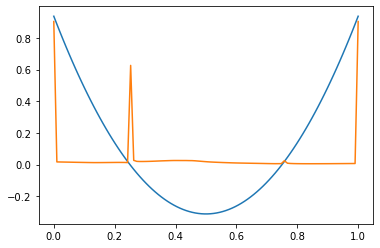

In [166]:
detect_disc(f_cont_2(x,None),x,model)

[0.01       1.         0.94234189 1.05765811 6.34239197 6.34239197]
[0.01       1.         0.94234189 1.05765811 6.34239197 6.34239197]


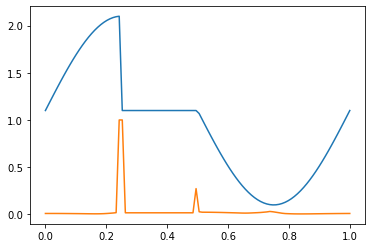

In [160]:
detect_disc(f_disc_2(x,None),x,model)

[ 1.00000000e-02  1.00000000e+00  1.00000000e+00  1.00000000e+00
 -3.77474996e-09  0.00000000e+00]
[ 1.00000000e-02  1.00000000e+00  1.00000000e+00  1.00000000e+00
 -2.38595532e-09 -1.38879463e-09]


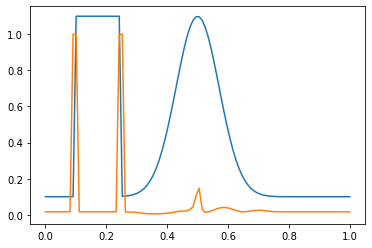

In [161]:
detect_disc(f_disc_3(x,None),x,model)

[1.00000000e-02 1.00000000e+00 8.12622530e-01 1.18737747e+00
 1.89251244e+01 1.89251244e+01]
[1.00000000e-02 1.00000000e+00 8.12622530e-01 1.18737747e+00
 1.89251244e+01 1.89251244e+01]


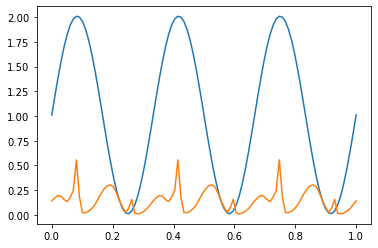

In [162]:
detect_disc(f_cont_3(x,None),x,model)

In [ ]:
# Store model